In [4]:
import sys
# setting path
sys.path.append('../')

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Ruta a las imágenes .tiff
TIFF_DIR = "/data/datasets/PANDA/PANDA_original/original/train_images"

# Listar los primeros 5 archivos .tiff del directorio
tiff_files = sorted([f for f in os.listdir(TIFF_DIR) if f.endswith(".tiff")])[:5]
assert len(tiff_files) >= 5, f"Se encontraron solo {len(tiff_files)} archivos TIFF"

# Mostrar cada imagen
plt.figure(figsize=(20, 10))
for i, filename in enumerate(tiff_files):
    img_path = os.path.join(TIFF_DIR, filename)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(filename[:8] + "...")

plt.suptitle("Primeras 5 imágenes TIFF del dataset", fontsize=16)
plt.tight_layout()
plt.show()


/tmp/ipykernel_66065/1713863606.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Modelo MIL cargado desde: /home/javitrucas/TFG/notebooks/models/panda/model_attention.pth
Capa de proyección de características creada: 2048 -> 1024

Buscando WSIs para visualización (una negativa con Pred.Prob < 0.7 y una positiva con Pred.Prob > 0.3)...


Buscando WSIs:   0%|          | 2/10616 [00:00<01:31, 116.04it/s]


--> Encontrada WSI Negativa (ISUP Grade 0, Pred.Prob 0.4942 < 0.7): 0005f7aaab2800f6170c399693a96917
--> Encontrada WSI Positiva (ISUP Grade 4, Pred.Prob 0.5269 > 0.3): 0018ae58b01bdadc8e347995b69f99aa

WSIs seleccionadas para visualización: 2

--- PROCESANDO WSI: 0005f7aaab2800f6170c399693a96917 ---
Features cargadas: torch.Size([128, 2048]) para 0005f7aaab2800f6170c399693a96917
Coordenadas cargadas: (128, 2) para 0005f7aaab2800f6170c399693a96917
Calculando pesos de atención para 128 parches...
Atención calculada. Total de parches: 128

Visualizando WSI: 0005f7aaab2800f6170c399693a96917
Predicción: 0.4942
Clasificación Real: Instancia Negativa (ISUP Grade: 0)
Thumbnail de WSI cargado (1728x1840 píxeles).
Heatmap guardado en: /home/javitrucas/TFG/results/panda_heatmaps/_heatmap.png


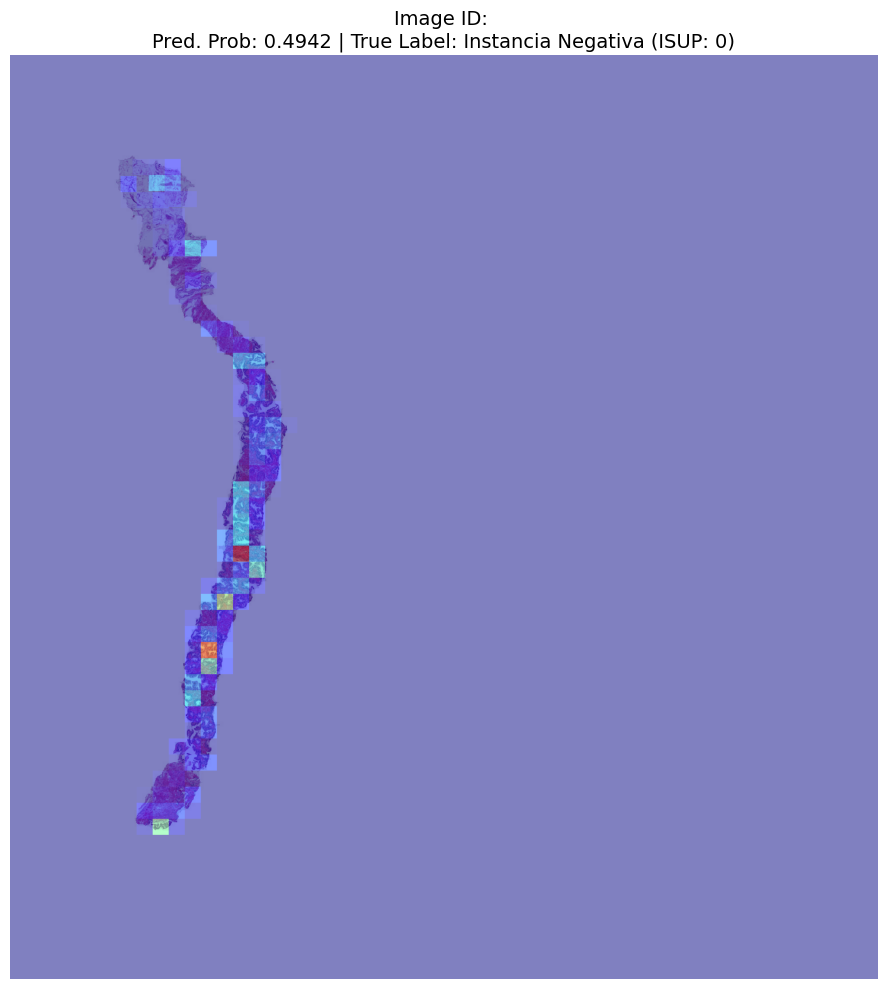

--- Proceso completado para WSI: 0005f7aaab2800f6170c399693a96917 ---

--- PROCESANDO WSI: 0018ae58b01bdadc8e347995b69f99aa ---
Features cargadas: torch.Size([129, 2048]) para 0018ae58b01bdadc8e347995b69f99aa
Coordenadas cargadas: (129, 2) para 0018ae58b01bdadc8e347995b69f99aa
Calculando pesos de atención para 129 parches...
Atención calculada. Total de parches: 129

Visualizando WSI: 0018ae58b01bdadc8e347995b69f99aa
Predicción: 0.5269
Clasificación Real: Instancia Positiva (ISUP Grade: 4)
Thumbnail de WSI cargado (368x1584 píxeles).
Heatmap guardado en: /home/javitrucas/TFG/results/panda_heatmaps/_heatmap.png


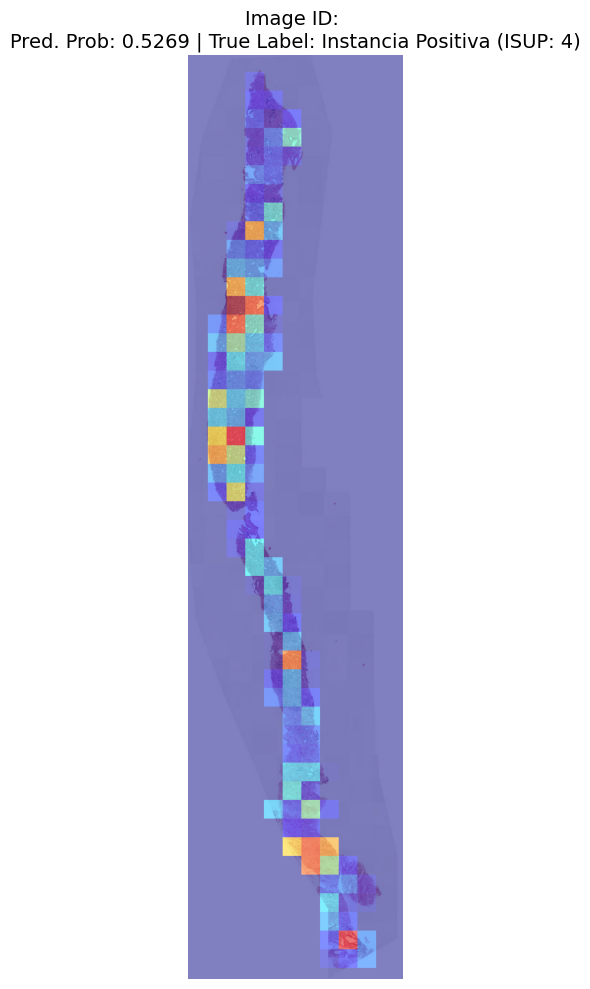

--- Proceso completado para WSI: 0018ae58b01bdadc8e347995b69f99aa ---

Proceso de visualización de WSIs completado.


In [2]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import torch
from tqdm import tqdm
from PIL import Image
import openslide # Crucial for WSI
from argparse import Namespace # Para config object
import torch.nn as nn # Necesario para nn.Linear
import h5py # Para leer archivos .h5

# Aumentar límite de PIL para imágenes grandes
Image.MAX_PIXELS_APPROX = None # Usar MAX_PIXELS_APPROX para PIL 9.1.0+ o MAX_IMAGE_PIXELS para versiones anteriores

# --- CONFIGURACIÓN DE RUTAS E IMPORTACIONES ---
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from scripts.model import MILModel
    from scripts.plot_utils import plot_wsi_and_heatmap, normalize
except (ImportError, ModuleNotFoundError) as e:
    print(f"Error importando módulos: {e}")
    print("Asegúrate de que la estructura de tu proyecto y el `sys.path` son correctos.")
    sys.exit()

# --- Configuración de guardado y paths ---
SAVE = True
SAVE_PATH = '/home/javitrucas/TFG/results/panda_heatmaps/'
SAVE_EXTENSION = 'png'
os.makedirs(SAVE_PATH, exist_ok=True)
plt.rcParams.update({'font.size': 20})

DATA_DIR = '/data/datasets/PANDA/PANDA_original/original/'
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
MODEL_PATH = '/home/javitrucas/TFG/notebooks/models/panda/model_attention.pth' 

# --- Parámetros de Extracción y Modelo ---
PATCH_SIZE = 512
MAX_PATCHES = 2000 
INPUT_FEATURE_DIM_ACTUAL = 2048 
INPUT_FEATURE_DIM_MODEL_EXPECTS = 1024 
FEATURE_DIM = 128 

# --- Parámetros de Visualización Específicos ---
WSI_LEVEL_FOR_THUMBNAIL = 2 

# --- PATHS REALES PARA FEATURES Y COORDENADAS ---
PANDA_FEATURES_ROOT = '/data/datasets/PANDA/PANDA_original/patches_512_preset/features_resnet50/'
PANDA_COORDS_ROOT = '/data/datasets/PANDA/PANDA_original/patches_512_preset/coords/'

# --- 1. CARGAR MODELO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MILModel(
    pooling_type='attention', 
    input_feature_dim=INPUT_FEATURE_DIM_MODEL_EXPECTS,
    feature_dim=FEATURE_DIM
)

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()
    print(f"Modelo MIL cargado desde: {MODEL_PATH}")
except FileNotFoundError:
    print(f"ERROR: No se encontró el modelo en: {MODEL_PATH}")
    sys.exit()
except Exception as e:
    print(f"ERROR al cargar el modelo: {e}")
    sys.exit()

feature_projector = nn.Linear(INPUT_FEATURE_DIM_ACTUAL, INPUT_FEATURE_DIM_MODEL_EXPECTS).to(device)
print(f"Capa de proyección de características creada: {INPUT_FEATURE_DIM_ACTUAL} -> {INPUT_FEATURE_DIM_MODEL_EXPECTS}")

# --- SELECCIONAR WSIs PARA VISUALIZAR (CASO NEGATIVO Y POSITIVO) ---
print("\nBuscando WSIs para visualización (una negativa con Pred.Prob < 0.7 y una positiva con Pred.Prob > 0.3)...")
selected_wsi_ids_for_visualization = []
df_train = None
try:
    df_train = pd.read_csv(CSV_PATH)
except Exception as e:
    print(f"ERROR: No se pudo cargar train.csv desde {CSV_PATH}: {e}")
    sys.exit()

found_negative_id = None
found_positive_id = None

for idx, row in tqdm(df_train.iterrows(), total=df_train.shape[0], desc="Buscando WSIs"):
    image_id = row['image_id']
    isup_grade = row['isup_grade']

    if found_negative_id and found_positive_id:
        break

    features_file_path = os.path.join(PANDA_FEATURES_ROOT, f"{image_id}.npy")
    coords_file_path = os.path.join(PANDA_COORDS_ROOT, f"{image_id}.h5")

    if not os.path.exists(features_file_path) or not os.path.exists(coords_file_path):
        continue

    try:
        all_features_np = np.load(features_file_path)
        if all_features_np.shape[1] != INPUT_FEATURE_DIM_ACTUAL:
            continue
        
        if all_features_np.shape[0] > MAX_PATCHES:
            all_features_np_subset = all_features_np[:MAX_PATCHES]
        else:
            all_features_np_subset = all_features_np

        features_tensor = torch.from_numpy(all_features_np_subset).float().to(device)

        with torch.no_grad():
            projected_features = feature_projector(features_tensor) 
            bag_tensor_for_model = projected_features.unsqueeze(0) 
            prediction, _ = model(bag_tensor_for_model)
            prediction_prob = torch.sigmoid(prediction).item()

    except Exception as e:
        continue

    if isup_grade == 0 and prediction_prob < 0.7 and found_negative_id is None:
        found_negative_id = image_id
        selected_wsi_ids_for_visualization.append({
            'id': image_id,
            'isup_grade': isup_grade,
            'prediction_prob': prediction_prob
        })
        print(f"--> Encontrada WSI Negativa (ISUP Grade 0, Pred.Prob {prediction_prob:.4f} < 0.7): {image_id}")
    elif isup_grade > 0 and prediction_prob > 0.3 and found_positive_id is None:
        found_positive_id = image_id
        selected_wsi_ids_for_visualization.append({
            'id': image_id,
            'isup_grade': isup_grade,
            'prediction_prob': prediction_prob
        })
        print(f"--> Encontrada WSI Positiva (ISUP Grade {isup_grade}, Pred.Prob {prediction_prob:.4f} > 0.3): {image_id}")
    
    if found_negative_id and found_positive_id:
        break

if not selected_wsi_ids_for_visualization:
    print("ERROR: No se encontraron WSIs que cumplan los criterios de visualización.")
    sys.exit()
else:
    print(f"\nWSIs seleccionadas para visualización: {len(selected_wsi_ids_for_visualization)}")


# --- BUCLE PARA PROCESAR CADA WSI SELECCIONADA ---
for wsi_info in selected_wsi_ids_for_visualization:
    WSI_TO_VISUALIZE_ID = wsi_info['id']
    true_label_raw = wsi_info['isup_grade']
    pre_calculated_pred_prob = wsi_info['prediction_prob']

    print(f"\n--- PROCESANDO WSI: {WSI_TO_VISUALIZE_ID} ---")

    wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{WSI_TO_VISUALIZE_ID}.tiff")
    if not os.path.exists(wsi_path):
        print(f"ERROR: WSI no encontrada en la ruta: {wsi_path}. Saltando.")
        continue 

    features_file_path = os.path.join(PANDA_FEATURES_ROOT, f"{WSI_TO_VISUALIZE_ID}.npy")
    coords_file_path = os.path.join(PANDA_COORDS_ROOT, f"{WSI_TO_VISUALIZE_ID}.h5")

    try:
        all_features_np = np.load(features_file_path)
        if all_features_np.shape[1] != INPUT_FEATURE_DIM_ACTUAL:
            print(f"ADVERTENCIA: Dimensión de feature incorrecta para {WSI_TO_VISUALIZE_ID}. Saltando.")
            continue
        
        if all_features_np.shape[0] > MAX_PATCHES:
            all_features_np = all_features_np[:MAX_PATCHES]

        features_tensor = torch.from_numpy(all_features_np).float().to(device)
        print(f"Features cargadas: {features_tensor.shape} para {WSI_TO_VISUALIZE_ID}")

    except Exception as e:
        print(f"ERROR al cargar/procesar features {features_file_path}: {e}. Saltando.")
        continue

    try:
        with h5py.File(coords_file_path, 'r') as f:
            if 'coords' in f: 
                all_coords = f['coords'][:] 
            else:
                print(f"ERROR: No se encontró 'coords' en {coords_file_path}. Saltando.")
                continue

        if all_coords.shape[0] != features_tensor.shape[0]:
            print(f"Advertencia: Coordenadas ({all_coords.shape[0]}) no coinciden con features ({features_tensor.shape[0]}). Ajustando.")
            all_coords = all_coords[:features_tensor.shape[0]] 
        print(f"Coordenadas cargadas: {all_coords.shape} para {WSI_TO_VISUALIZE_ID}")
    except Exception as e:
        print(f"ERROR al cargar/procesar coordenadas {coords_file_path}: {e}. Saltando.")
        continue


    # --- 3. OBTENER PESOS DE ATENCIÓN ---
    print(f"Calculando pesos de atención para {features_tensor.shape[0]} parches...")
    with torch.no_grad():
        projected_features = feature_projector(features_tensor) 
        bag_tensor_for_model = projected_features.unsqueeze(0) 
        
        _, attention_weights = model(bag_tensor_for_model)
        
        attention_weights = attention_weights.squeeze(0).cpu().numpy() 
        # prediction_prob ya la tenemos pre-calculada y es la que nos sirvió para seleccionar la WSI

    print(f"Atención calculada. Total de parches: {len(attention_weights)}")

    normalized_attention = normalize(attention_weights)

    # --- 4. CARGAR WSI Y VISUALIZAR ---
    print(f"\nVisualizando WSI: {WSI_TO_VISUALIZE_ID}")
    print(f"Predicción: {pre_calculated_pred_prob:.4f}")

    if true_label_raw > 0:
        true_label_display = "Instancia Positiva"
    else:
        true_label_display = "Instancia Negativa"
    print(f"Clasificación Real: {true_label_display} (ISUP Grade: {true_label_raw})")

    try:
        slide = openslide.OpenSlide(wsi_path)
        
        thumbnail_dims = slide.level_dimensions[WSI_LEVEL_FOR_THUMBNAIL]
        
        wsi_thumbnail = slide.read_region((0, 0), WSI_LEVEL_FOR_THUMBNAIL, thumbnail_dims)
        wsi_thumbnail = np.array(wsi_thumbnail)[:, :, :3] 
        
        downsample_factor = slide.level_downsamples[WSI_LEVEL_FOR_THUMBNAIL] 
        
        slide.close()
        print(f"Thumbnail de WSI cargado ({wsi_thumbnail.shape[1]}x{wsi_thumbnail.shape[0]} píxeles).")

    except Exception as e:
        print(f"ERROR: No se pudo cargar la WSI thumbnail para {WSI_TO_VISUALIZE_ID}: {e}. Saltando.")
        continue

    if len(all_coords) != len(normalized_attention):
        print("CRÍTICO: Coordenadas y scores de atención NO COINCIDEN. El heatmap será incorrecto. Saltando.")
        continue

    # Llamar a la función plot_wsi_and_heatmap con el image_id vacío para limpiar el título
    plot_wsi_and_heatmap(
        wsi_image=wsi_thumbnail, 
        attention_scores=normalized_attention,
        patch_coords=all_coords, 
        patch_size=PATCH_SIZE,    
        level_downsample_factor=downsample_factor, 
        image_id="", # Vacío para que no aparezca en el título del plot (si el plotter lo usa)
        pred_prob=pre_calculated_pred_prob,
        true_label=f"{true_label_display} (ISUP: {true_label_raw})", # Formato de etiqueta real
        save_path=SAVE_PATH if SAVE else None,
        save_extension=SAVE_EXTENSION
    )

    print(f"--- Proceso completado para WSI: {WSI_TO_VISUALIZE_ID} ---")

print("\nProceso de visualización de WSIs completado.")